## Time Series Forecasting Models with MLflow

Time Series forecasting uses **statistical, machine learning** and even **deep learning** techniques to learn the **historical data** pattern like **trend** and **seasonality** and predict the **future** values.

Time series `y` is represented commonly as, 
$y(t) = b(t) + s(t) + e(t)$ <br>
Where $b(t)$ -> trend of series, $s(t)$ -> seasonality, $e(t)$ -> residual / error term

Below are few models used for time series forecasting:  
* **SARIMAX**: A statistical model that captures trend, seasonality, and also includes external factors (exogenous variables) to improve forecasts.
* **Facebook Prophet**: A model designed to handle strong seasonality and holiday effects, easy to use and works well with business time series.
* **ML Regression Models**: Machine learning models that uses lag values and date time features (day, week, month) with additional explanatory variables to learn patterns in the data and predict future values. 
* **RNN (Recurrent Neural Networks)** and **LSTM (Long Short-Term Memory)**: A deep learning model that processes sequential data by remembering past values when predicting future ones.
* **Transformers**: The latest deep learning models that use attention mechanisms to capture both short and long-range dependencies, often achieving state-of-the-art forecasting results.

There isn’t a one-size-fits-all solution, different models like SARIMAX, Prophet, or deep learning approaches may perform differently depending on the data and the application. Finding the right model often takes many experiments, where it is important to track different algorithms with adjusted hyperparameters, with or without various data preprocessing steps and exogenous features. In this process, it becomes crucial to keep track of inputs, evaluation metrics, and model versions, with so many moving parts it’s difficult to compare to find best model. This is where tools like **MLflow** helps by providing experiment tracking, model versioning, etc to ensure reproducibility and make deployment reliable.

**MLflow** is an open-source platform, focusing on the full lifecycle of machine learning projects to be **manageable, traceable, and reproducible**. It provides auto logging, one liner intergrations with ML libraries, etc. 
In this notebook, we use **MLflow** to:
- Track experiments  
- Log datasets, parameters, metrics, and models  
- Manage model versions with a central registry  

We will test different models for time series forecasting:
- **Classical ML model**: SARIMAX  
- **Probabilistic model**: Facebook Prophet  
- **Deep Learning model**: PatchTST (using tsai)  

### Business Problem Statement:
Understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients.
You are provided with the data of 145k wikipedia pages and daily view count.

**Concepts Used:**
- Data Preprocessing
- Time Series forecasting- ARIMA, SARIMA, SARIMAX
- Time Series forecasting- Prophet
- Time Series forecasting- TSAI (PatchTST)

### Dataset

Datalink: https://drive.google.com/drive/folders/1mdgQscjqnCtdg7LGItomyK0abN6lcHBb


**Data Dictionary:**

There are two csv files given

1. train_1.csv: In the csv file, each row corresponds to a particular **article**  and each column corresponds to a particular date. The values are the **number of visits** on that date. There is total `550 days` data present.

    The page name contains data in this format: `SPECIFIC NAME_LANGUAGE.wikipedia.org _ACCESS TYPE_ACCESS ORIGIN` having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)

2. Exog_Campaign_eng: This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

    There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

In [ ]:
# !pip install mlflow
# !pip install scikit-learn
# !conda install -c conda-forge scikit-learn

In [2]:
import pandas as pd
import numpy as np
import os
import re

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates

In [3]:
raw_df = pd.read_csv('train_1.csv')
raw_df.head(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


The dataset contains **1.45 lakh web pages (articles)** with their corresponding **daily visit counts over 550 days** (from **2015-07-01** to **2016-12-31**). Each row represents a unique webpage, and each column (date) represents the number of visits on that day.  

In [4]:
raw_df.isna().sum().to_frame("count").T  # null values in each column, i.e. each date

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
count,0,20740,20816,20544,20654,20659,20483,20664,20294,20244,...,3853,3584,3189,3744,3918,3701,3822,3826,3635,3465


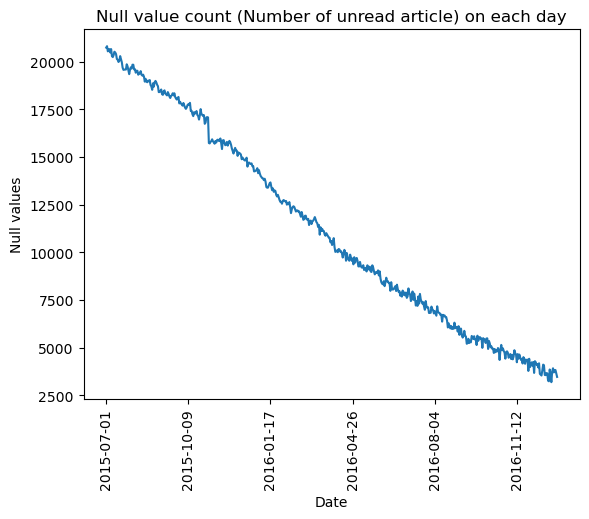

In [5]:
raw_df.isna().sum()[1:].plot()  # without 1st row -> page
plt.title("Null value count (Number of unread article) on each day")
plt.xlabel('Date')
plt.ylabel('Null values')
plt.xticks(rotation=90)
plt.show()  # null values are showing a decreasing trend

We plotted the null value counts per day and observed a **decreasing trend in missing values**, likely due to **new web pages** being created after the dataset recording started.

**Missing Value Handling**
1. **Row-level nulls:** Drop rows where there are no visit counts at all for a particular article.  

2. **Threshold-based filtering:** Applied a threshold of **300 days**. Remove articles with fewer than 300 recorded days of data.  

3. **Fill remaining nulls:** For the filtered data, remaining missing values are filled with **0**, assuming no visits occurred on those days.  

In [7]:
raw_df2=raw_df.dropna(how='all')  # remove rows with zero inputs; (includes pages without name)
raw_df2=raw_df2.dropna(thresh=300)  # remove rows where webpage have less number of days record 
raw_df2.isna().sum().to_frame("count").T

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
count,0,9666,9683,9442,9561,9542,9386,9554,9206,9214,...,908,830,455,950,1006,901,943,959,941,677


In [8]:
raw_df2=raw_df2.fillna(0).reset_index(drop=True)

**Feature Extraction** from **Page** column, it contains encoded metadata each seperated by either underscore '_' or period '.'.

Using **string split** with regex, we extracted the **Article Title**, **Language**, **Access Type**, **Access Origin**.  

**Concat** the features with the original dataframe to use these feature for futher **analysis** and group data on **languages** for **time series**. 

In [9]:
def split_page(page):
    words = re.split(r'_|\.', page)  # split on "_" or "." 
    return " ".join(words[:-5]), words[-5], words[-2], words[-1]  #  returns 'Title', 'Language', 'Access_type','Access_origin'

# split_page('2NE1_zh.wikipedia.org_all-access_spider')  # e.g.

page_detail = raw_df2.Page.apply(lambda x: split_page(str(x)))
# page_detail

In [13]:
df_page = pd.DataFrame(page_detail.to_list(), columns=['Title', 'Language', 'Access_type','Access_origin'])
# df_page

df_page = pd.concat([raw_df2, df_page], axis = 1)
df_page.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access_type,Access_origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
4,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,32.0,19.0,23.0,17.0,17.0,50.0,5566,zh,all-access,spider


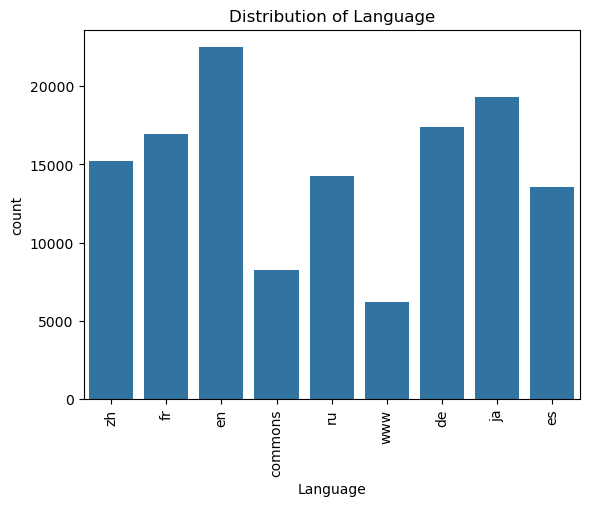

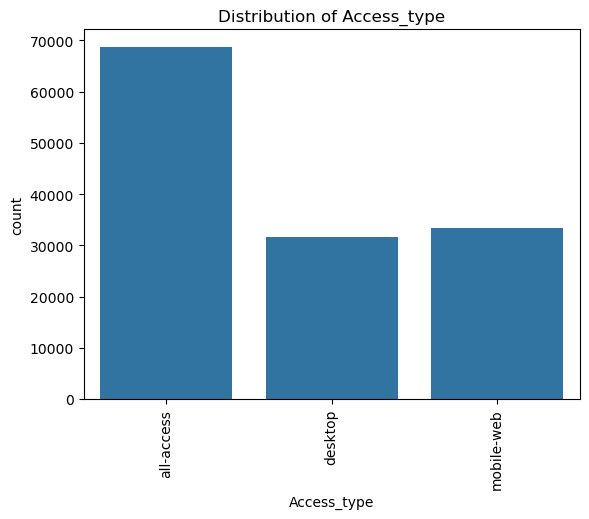

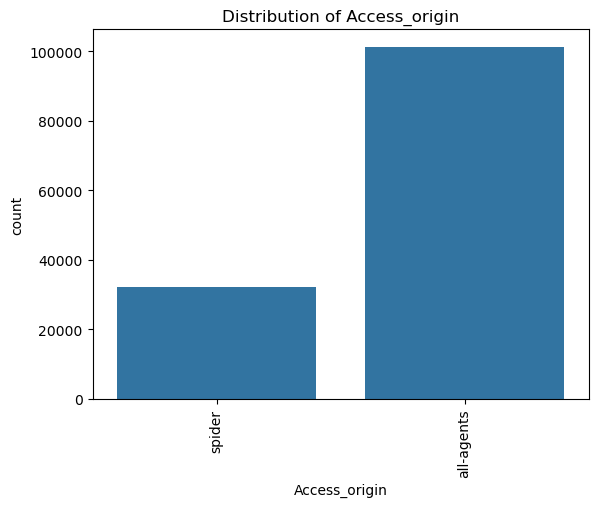

In [14]:
for x in df_page.columns[-3:]:
  sns.countplot(df_page, x=x)
  plt.title(f'Distribution of {x}')
  plt.xticks(rotation=90)
  plt.show()

**Distribution** of Web pages by **Meta data** to better understand the data balance.

- `Language`: The dataset contains **7 different languages** along with some unknown pages. **English** Wikipedia pages dominate (~22K), followed by **Japanese** and **German** pages.  
- `Access Type`: Most pages are accessible across **all platforms (~70K pages)**. The remaining pages are almost equally divided between **desktop-only** and **mobile web-only** access.  
- `Access Origin`: A majority of the data (**~100K pages**) comes from **agents** (direct user access). The rest is collected via web crawlers **(spiders)**.  

**Handling Inconsistent Data:** Some web pages such as `commons.wikimedia` and `mediawiki` represent image repositories rather than articles.  
These pages are not considered for forecasting article visits, so they are marked as `NA` in the `Language` column.

**Transformation:** The dataset contains **time-series columns (dates)** as features and **page metadata** (Title, Language, Access type, Access origin).  
- To make the data usable for forecasting we group by Language. Aggregate all pages of the same language to take the mean of page views per day. This results in a **daily** time series of **average views per language**.  

In [17]:
display(df_page[df_page['Language']=='commons'].Page.head(3))

df_page[df_page['Language']=='www'].Page.head(3)

12271      Accueil_commons.wikimedia.org_all-access_spider
12272    Atlas_of_Asia_commons.wikimedia.org_all-access...
12273    Atlas_of_Europe_commons.wikimedia.org_all-acce...
Name: Page, dtype: object

17850          API_www.mediawiki.org_all-access_all-agents
17851    API:Account_creation_www.mediawiki.org_all-acc...
17852    API:Allimages_www.mediawiki.org_all-access_all...
Name: Page, dtype: object

In [18]:
# replace commons and www as no language, these pages are for images
df_page['Language'] = df_page['Language'].replace(['www', 'commons'], 'NA')
df_page['Language'].value_counts().to_frame('count').T

Language,en,ja,de,fr,zh,NA,ru,es
count,22486,19295,17362,16948,15211,14494,14270,13551


In [20]:
df_page = df_page.drop(columns=["Page", 'Title', 'Access_type', 'Access_origin'])
df_ts = df_page.groupby("Language").agg("mean").T.reset_index()  # mean of each column(date) for each language
df_ts.columns = ['date', 'NA', 'de', 'en', 'es', 'fr', 'ja', 'ru', 'zh']

df_ts['date'] = pd.to_datetime(df_ts['date'], format='ISO8601', dayfirst=True)
df_ts.set_index('date', inplace=True)
df_ts.head(3)

,NA,de,en,es,fr,ja,ru,zh
date,,,,,,,,
2015-07-01,102.733545,763.765926,3767.328604,1127.485204,499.092872,614.637160,663.199229,272.498521
2015-07-02,107.663447,753.362861,3755.158765,1077.485425,502.297852,705.813216,674.677015,272.906778
2015-07-03,101.769629,723.074415,3565.225696,990.895949,483.007553,637.451671,625.329783,271.097167


In [3]:
# Save preprocessed data, to further feed into timeseries models
# df_ts.to_csv("prep_ts.csv")
df_ts = pd.read_csv("prep_ts.csv", index_col='date')
df_ts.index = pd.to_datetime(df_ts.index, format='ISO8601', dayfirst=True)
df_ts.head(3)

,NA,de,en,es,fr,ja,ru,zh
date,,,,,,,,
2015-07-01,102.733545,763.765926,3767.328604,1127.485204,499.092872,614.637160,663.199229,272.498521
2015-07-02,107.663447,753.362861,3755.158765,1077.485425,502.297852,705.813216,674.677015,272.906778
2015-07-03,101.769629,723.074415,3565.225696,990.895949,483.007553,637.451671,625.329783,271.097167


- Reduced noise from page-level variations and produced a clean **multivariate time series**, one per language. Making it feasible to forecast future web page views per language.  
- These forecasts can guide **advertising companies** to identify which **language domains** attract the most views and the **best periods** to place targeted ads.

**Exploratory Analysis of Time Series by Language**
- **Line Plot** of `Web page views per day per language`  

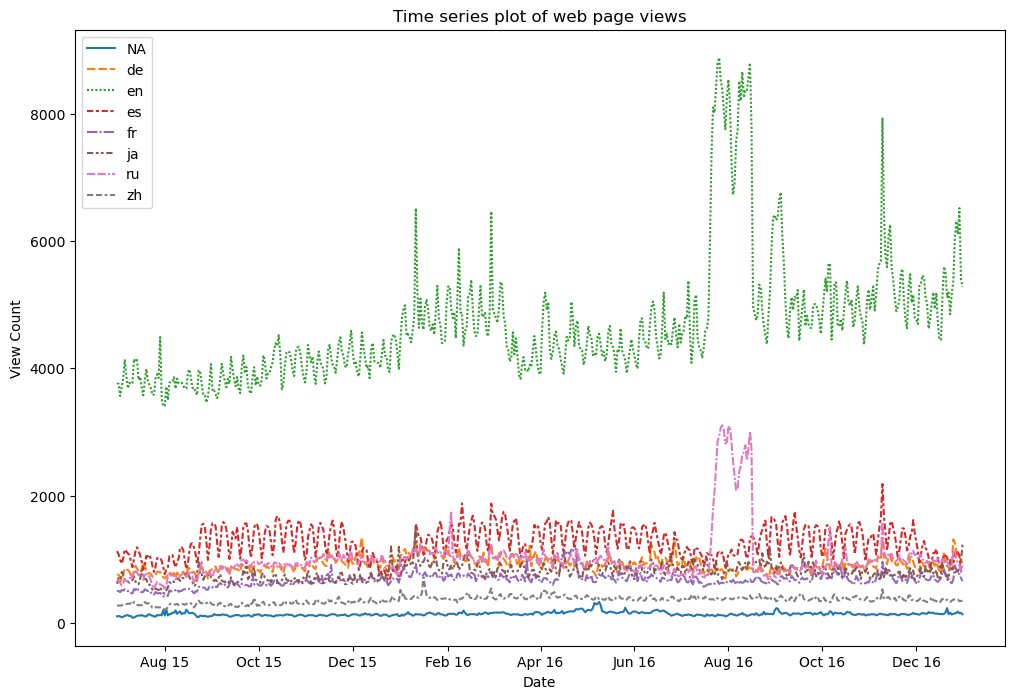

In [21]:
plt.figure(figsize=(12,8))
sns.lineplot(df_ts)
plt.title("Time series plot of web page views")
plt.ylabel("View Count")
plt.xlabel("Date")

ax = plt.gca()  # get current axis 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.show()

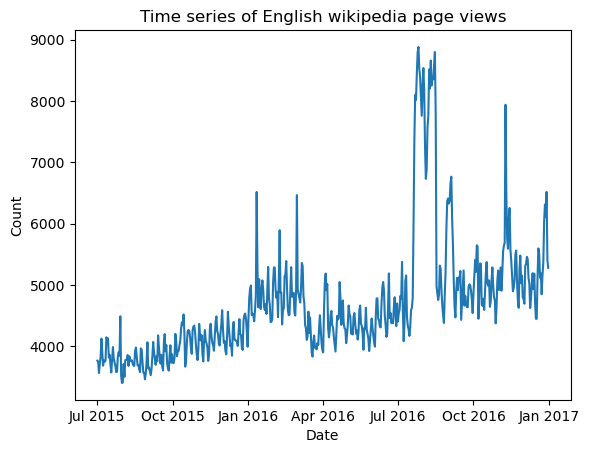

In [22]:
sns.lineplot(df_ts['en'])
plt.title('Time series of English wikipedia page views')
plt.ylabel("Count")
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.show()

 The dataset contains daily webpage views from **July 2015 to December 2016** across multiple languages.  
The trends differ significantly by language:

- **English (en)** has overall **increasing trend** in webpage views. Noticeable **bump between Jan–Mar 2016**, above the trend line. **Strong spikes in Aug–Sep 2016**, which align with **external campaign events** (exogenous variables provided).  

- **Russian (ru)** has elatively **low volume of views**. Similar to english webpages, shows **spikes in Aug–Sep 2016**, indicating common external influence.  

- **Spanish (es)** displays a **wave-like seasonal pattern** increasing from Aug to Dec 2015, decline in Jan 2016, rising again until Aug 2016. Suggests a **double seasonal cycle** with irregular season lengths.  

- **Chinese (zh) & NA (commons/mediawiki)** nearly **linear with no strong upward trend**. Webpage views remain relatively stable over time.

**Insights**
- External **campaign events** strongly influence English and Russian page views, creating clear spikes.  
- Spanish shows **complex seasonality**, requiring models capable of handling **multiple seasonal cycles**.  
- Chinese and NA domains contribute little to forecasting due to their **flat patterns**.  

These observations will guide **model selection** (e.g., Prophet for multi-seasonality, SARIMAX for exogenous effects, PatchTST for irregular cycles).



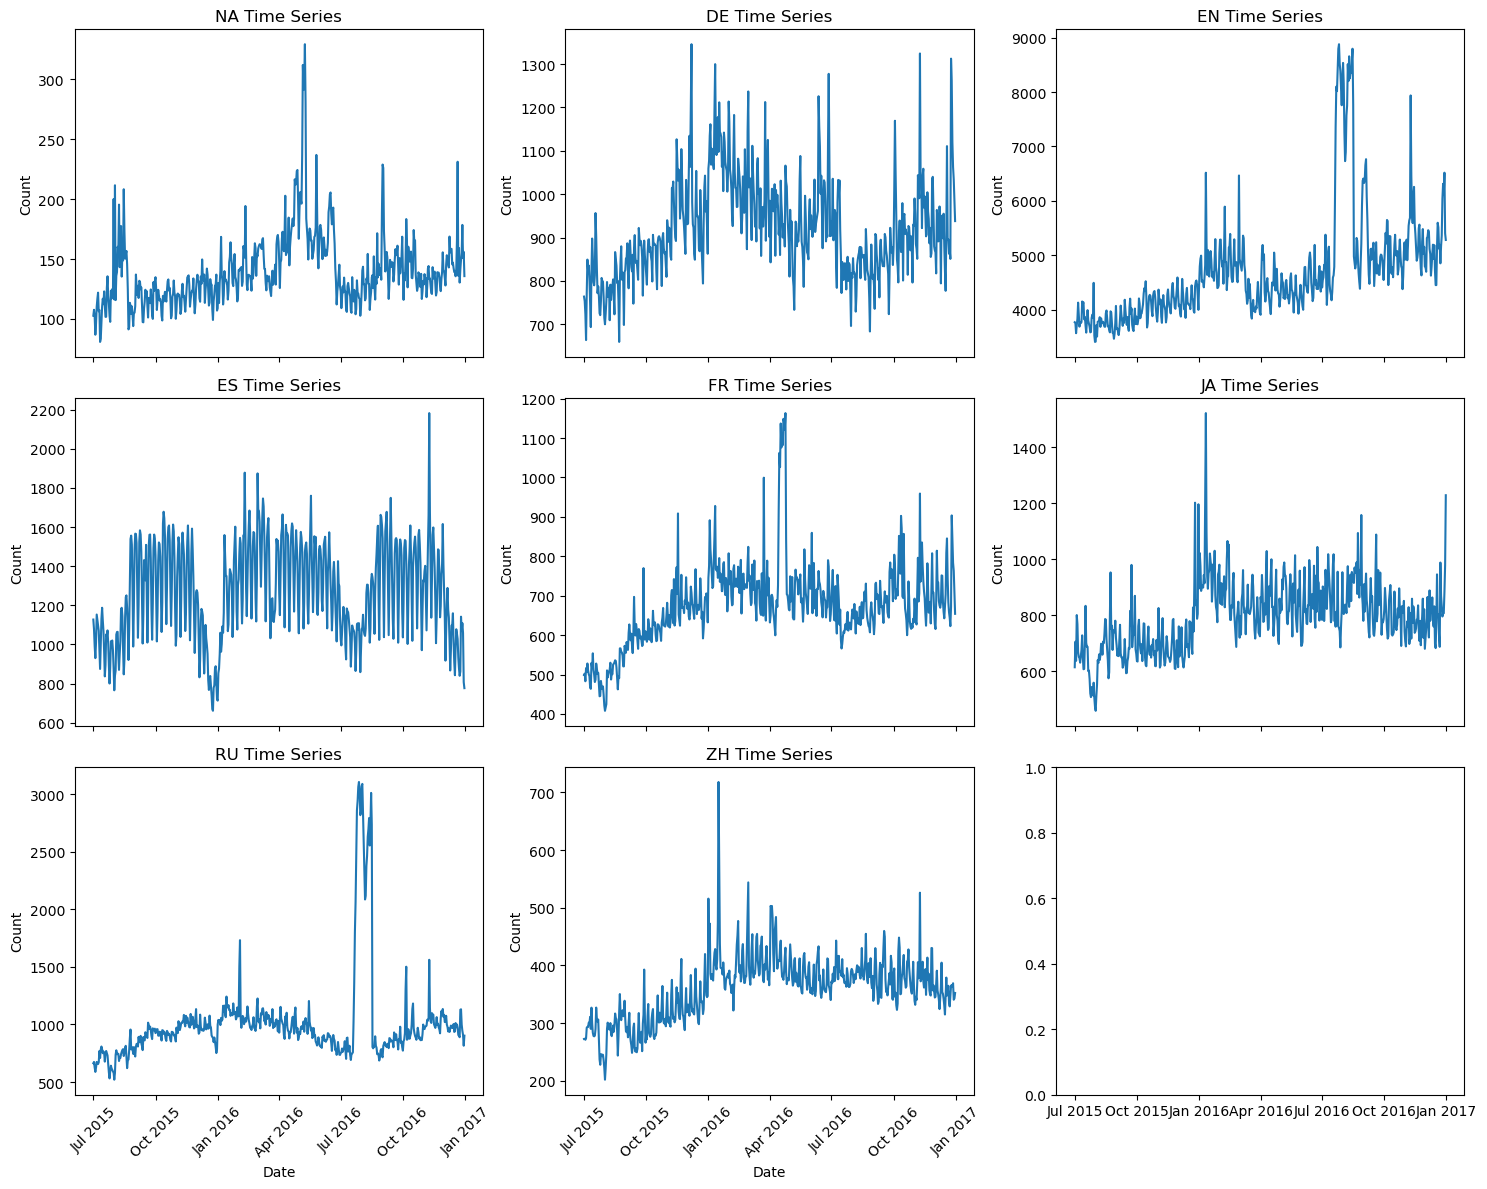

In [8]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(15, 12))  # 2,4, figsize=(12, 8),
axes = axes.flatten()  # easier to iterate

for i, lang in enumerate(df_ts.columns):
    ax = axes[i]
    sns.lineplot(data=df_ts, x=df_ts.index, y=lang, ax=ax)
    
    ax.set_title(f"{lang.upper()} Time Series")
    ax.set_ylabel("Count")
    ax.set_xlabel("Date")
    
    # format x-axis date
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("language_webviews_timeseries.png") 
plt.show()

### Decomposition and Differentiation

**Stationarity:** For many **time series forecasting models** (e.g., ARIMA, SARIMAX), the data is required to be **stationary**, where the **mean, variance, and autocorrelation** remain constant over time. This makes it easier for models to capture relationships without being biased by trends or varying seasonality.

**Augmented Dickey-Fuller (ADF) Test**
We defined a function to perform the **ADF test**, which statistically checks if a series is stationary. (Consider significance level - 0.05)

- *Null Hypothesis (H₀):* The series has a unit root (non-stationary).  
- *Alternative Hypothesis (H₁):* The series is stationary.  

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

def adf_test(x):
    result=adfuller(x)
    print(f'ADF Stastistic: {result[0]}')
    print(f'p-value: {result[1]}')

en_ts = df_ts['en'].copy()
adf_test(en_ts)

ADF Stastistic: -2.373562974569941
p-value: 0.14933749437355304


Applying this to the **English webpage views series** (our primary focus for forecasting), the result indicated:  
- **Non-stationary series**  further transformation required.  

To better understand the structure, we **decomposed** the time series into:  
1. **Trend** (Long-term movement in the data) - Clear **increasing trend** with visible spikes in **August–September**.  
2. **Seasonality** (Repeating short-term patterns) - Seasonal component ranges roughly between **-250 to +250** with consistent frequency. Suggests a **weekly seasonal** period (7 days).  
3. **Residuals** The remainder after removing trend and seasonality. Residuals appear stationary, supporting an **additive decomposition model**.  

**Theoretical Note:**  
Additive decomposition assumes observed data = **Trend + Seasonality + Residual**.  
Multiplicative decomposition (Trend × Seasonality × Residual) is used when seasonal variation grows with the trend, which is not the case here.

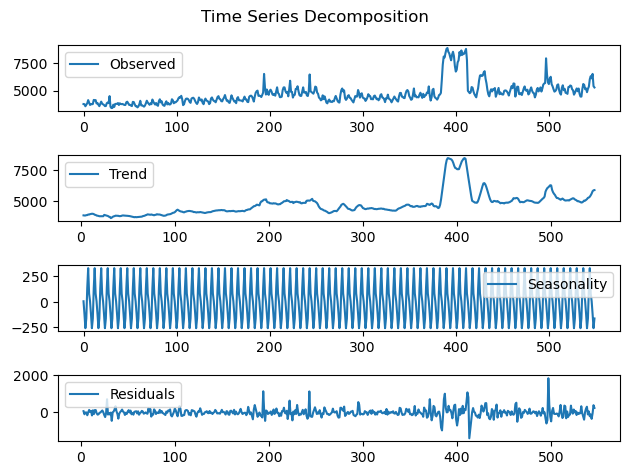

In [24]:
decomposition = seasonal_decompose(en_ts.values, model='additive', period = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4, 1)
plt.suptitle('Time Series Decomposition')
axs[0].plot(en_ts.values,label='Observed')
axs[0].legend()
axs[1].plot(trend, label='Trend')
axs[1].legend()
axs[2].plot(seasonal,label='Seasonality')
axs[2].legend()
axs[3].plot(residual, label='Residuals')
axs[3].legend()
plt.tight_layout()
plt.show()

In [28]:
# check stationarity on residuals, i.e after removing trend and seasonality [not required as well; differenced series acf and pacf is required]
ts_resid_add=pd.DataFrame(residual).fillna(0)[0].values
adf_test(ts_resid_add)

# ts_season_add=pd.DataFrame(seasonal).fillna(0)[0].values
# adf_test(ts_season_add)  # stationary, but do we consider seasonality in acf and pacf, [no] 

ADF Stastistic: -11.521953006063757
p-value: 4.020092431859705e-21


The residuals are **stationary**, as p value is less than `0.05`, we accept the null hypothesis.
But we cannot directly feed them into forecasting models since they only represent the leftover noise.

To transform the original series into a stationary one, we applied **first-order differencing**:  

Y't = Yt - Y{t-1}  (subtracting the current value with t-1 day value)

- This removes the trend by subtracting each day’s value from its previous day.  
- Running the **ADF test on the differenced series** showed stationarity, as p_value is less than 0.05, accepting the alternate hypothesis. 

Thus, the **differenced series** is suitable as input for forecasting models such as ARIMA/SARIMAX.

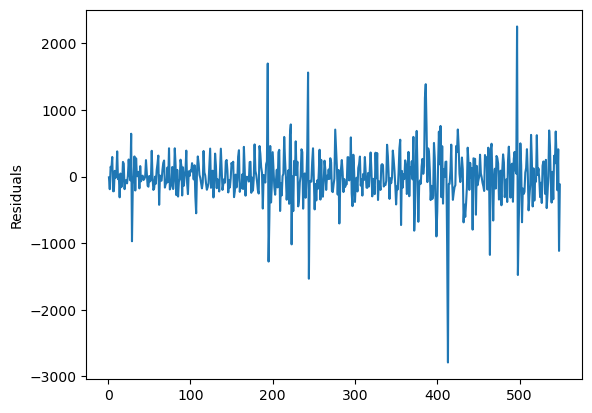

ADF Stastistic: -8.273590058493818
p-value: 4.721271966433609e-13


In [13]:
en_ts_diff = en_ts - en_ts.shift(1)
plt.plot(en_ts_diff.values)
plt.ylabel("Residuals")
plt.show()

adf_test(en_ts_diff[1:])  # remove the first nan value, created due to differencing

### ACF and PACF
Understanding **ACF (Autocorrelation Function)** : Measure of correlation between the series at the current time step and its (previous time step) **lagged values**.  
- ACF helps identify the **Moving Average (MA) component (`q`)** in ARIMA models.  
- High correlation at certain lags indicates that past values strongly influence the current observation.  
- If the ACF cuts off after a few lags but the PACF gradually decreases instead, it suggests an **MA model**.
- The lag value until the cut off is considered for 'MA' component in the model.

Understanding **PACF (Partial Autocorrelation Function)** : Measure of **direct correlation** between the series and its lag values, while removing the indirect effects of other lags.  
- PACF is used to identify the **Autoregressive (AR) component (`p`)** in ARIMA models.  
- If the PACF cuts off after a few lags but the ACF gradually decreases instead, it suggests an **AR model**.
- The lag value until the cut off is considered for 'AR' component in the model.

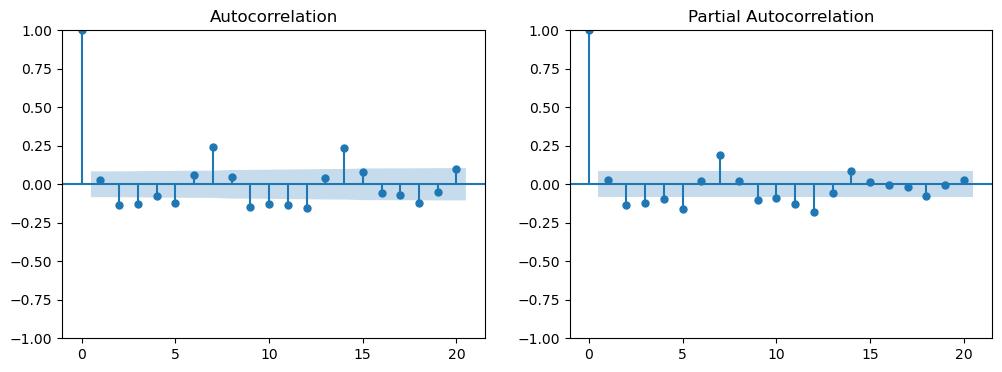

In [15]:
# acf=plot_acf(ts_resid_add, lags=20)  # resid decompose
# pacf=plot_pacf(ts_resid_add, lags=20)

# acf=plot_acf(seasonal,lags=20)  # season decompose
# pacf=plot_pacf(seasonal,lags=20)

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes = axes.flatten()
acf=plot_acf(en_ts_diff[1:],lags=20, ax=axes[0])  # differenced ts
pacf=plot_pacf(en_ts_diff[1:],lags=20, ax=axes[1])

ACF and PACF plots for **20 lag values** were analyzed.  
- Significant correlation observed for the **for lag 2 to lag 5 values** in both plots.  
- Weekly seasonality is evident with strong correlation at **multiples of lag = 7**.  

- From ACF we estimate `q` (MA order) is between 1-5.  
- From PACF we estimate `p` (AR order) is between 1-5.  
- From differencing (earlier ADF test) we found `d` (Integration order) is equal to 1.  

Together, these form the **ARIMA (p,d,q)** model structure.  
Adding seasonal terms (P,D,Q,s) extends it to **SARIMA/SARIMAX** for handling seasonality and exogenous factors.

## Model Comparisons

**MLflow Setup :**
We start by setting the tracking server URI to localhost (or any cloud service) for centralized MLflow Tracking Server. This allows you to log experiment runs and artifacts to a remote server instead of just a local file system for sharing and reproducing results. It supports auto logging, which automatically logs parameters, metrics, datasets and models without explicit code, reduces manual effort and ensures consistency.

```python
mlflow.set_tracking_uri("http://127.0.0.1:5000")
```

**Evaluation Metrics** (we'll be using below two metrics)

1. **RMSE (Root Mean Squared Error):** Measures the square root of the average squared differences between actual and predicted values. It penalizes larger errors more heavily and is sensitive to the scale of data.
2. **MAPE (Mean Absolute Percentage Error):** Calculates the absolute percentage difference between actual and predicted values. Easy to interpret since it expresses error as a percentage.
* **Other metrics:**
  * **MAE (Mean Absolute Error):** More robust, less sensitive to outliers compared to RMSE.
  * **R² / Adjusted R²:** Indicate how much variance is explained by the model, reflecting its ability to learn patterns in the data.

**Experiment Tracking with MLflow**: To simplify comparison across models and ensure reproducibility, we will use following methods from MLflow:

* **Tracking Runs** (`start_run`): MLflow experiments tracked for each run can have a name and tags for easy identification.
Inside a run, we log input datasets, model hyperparameters, evaluation metrics (RMSE, MAPE, etc.), serialized model artifacts (pickle file) for reuse.
* **Data logging** (`log_input`): Create a dataset object specifying the dataframe, source, alias name, and target column to record the data used in each experiment.
* **Parameter logging** (`log_params`): Track model-specific parameters such as `order` in SARIMAX, `changepoint_prior_scale` in Prophet, and `architecture` details in deep learning models like TSForecaster.
* **Metric logging** (`log_metrics`): Use uniform metrics (RMSE, MAPE) across all models to make performance comparisons consistent and fair.
* **Model logging** (`log_model`): Save fitted models with alias names, serialization type, and input examples to capture model signature. These stored models can be directly deployed for predictions after evaluation.

**Utility Functions**
* **Performance Measure:** A helper function that takes the actual and predicted values from a model and returns evaluation metrics (RMSE and MAPE).
* **Plot Forecasts:** A visualization function that accepts train, test, and forecasted values to generate line plots. It helps visually compare how well the model fits historical data and how accurately it predicts on the test set.

In [137]:
import mlflow
from mlflow.models.signature import infer_signature
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (mean_squared_error as mse,
                             mean_absolute_percentage_error as mape)

# performance metrics
def performance(actual, predicted):
    rmse = round(mse(actual, predicted) ** 0.5, 2)
    mape_val = round(mape(actual, predicted), 4)
    print('RMSE: ', rmse)
    print('MAPE: ', mape_val)
    return rmse, mape_val

In [100]:
# line plot - actual vs forecast 
def plot_forecast(train, test, fc_series, title):
    sns.lineplot(train, label='Training')
    sns.lineplot(test, label='Actual')
    sns.lineplot(fc_series, label='Forecast')
    
    plt.title(title)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # bi-monthly interval
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))  # format "mmm-yy" 
    plt.show()

### 1.1 SARIMA 

SARIMA (Seasonal Autoregressive Integrated Moving Average) extends ARIMA by incorporating **seasonal components**, making it suitable for time series that show repeating patterns over time (e.g., weekly, monthly trends). It includes:

* **P, D, Q**: Seasonal counterparts of p, d, q.
* **s**: Seasonal cycle length (e.g., 7 for weekly seasonality).

SARIMA is ideal for modeling **seasonal behaviors** in time series data. when applying SARIMA with seasonal period (s = 7 for weekly patterns) and keeping seasonal differencing (D=0) improves the model’s performance on our data.

First-order differencing (d=1) was sufficient to make time series stationary. And to keep the comparison between differnt models, we will use order and seasonal order values for which the model performs best which is performed in different notebook (prior to this project). 
The order value we came up with is 4,1,3 respectively for p,d,q. and 3,0,2,7 for P,D,Q,s

Seperate out the english webpage dataframe, and create a mlflow dataset object which can be stored for data lineage and versioning.
mlflow has method `data.from_pandas`, to take in dataframe with its source which can be from local or remote server, alias name, and target column specification.

In [6]:
en_ts_df = en_ts.to_frame(name='en')
en_ts_df.index = pd.to_datetime(en_ts_df.index, format='ISO8601', dayfirst=True)
en_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   en      550 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


In [30]:
en_ts_df.to_csv("en_ts.csv")

# Create a Dataset object
en_ts_dataset = mlflow.data.from_pandas(en_ts_df, source="./en_ts.csv", 
                                        name="en_page_timeseries", targets="en")

C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for './en_ts.csv'. Exception: 
  return _dataset_source_registry.resolve(
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


**Experiment Setup**

**Train-Test Split**: The dataset is split into **training** and **test sets**, with the **last 20 days reserved as test data**. The goal is to forecast these 20 days and compare predictions against the true values.  

**Set tracking URI** to **`localhost:5000`**.  
- started run with the alias **`SARIMA_Forecast`**.  
- As discussed earlier we log input dataset, model hyperparameters, performance metrics, trained model artifact  

SARIMAX Model
- We use **SARIMAX** from `statsmodels`.  
- Pass training series with specified `order (4,1,3)` and `seasonal_order (3,0,2,7)`.  
- Generate **20-day forecasts** with predicted mean values.  

In [31]:
train = en_ts_df['en'][:-20]  # keep last 20 days to test forecast
test = en_ts_df['en'][-20:]

# start mlflow ui before to set tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run(run_name="SARIMA_Forecast"):
    mlflow.log_input(en_ts_dataset)
    mlflow.log_artifact("en_ts.csv")
    
    order = (4,1,3); seasonal_order = (3,0,2,7); steps = 20;  # alpha = 0.02  # params
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    fc_obj = model_fit.get_forecast(20, alpha=0.02)
    fc = fc_obj.predicted_mean
    fc_series = pd.Series(fc.values, index=test.index)
    
    rmse, mape_val = performance(test, fc_series)
    
    # Log params, metrics, model 
    mlflow.log_params({"order": order, "seasonal_order": seasonal_order, "steps": steps})
    mlflow.log_metrics({"mape": mape_val, "rmse": rmse})
    
    # input_example = en_ts_df.reset_index(names='date').head()
    mlflow.sklearn.log_model(sk_model=model_fit, name="SARIMA_fitted_model",
    serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


RMSE:  624.16
MAPE:  0.0844


2025/10/05 23:42:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SARIMA_Forecast at: http://127.0.0.1:5000/#/experiments/0/runs/e5e5baf776f64dbbb5d4030e1fcb93c2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


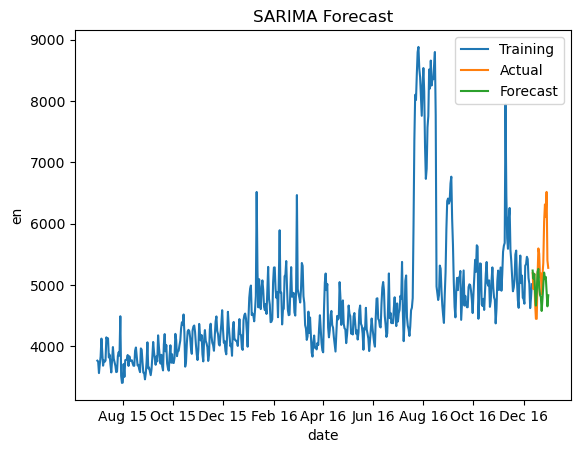

In [32]:
plot_forecast(train, test, fc_series, "SARIMA Forecast")

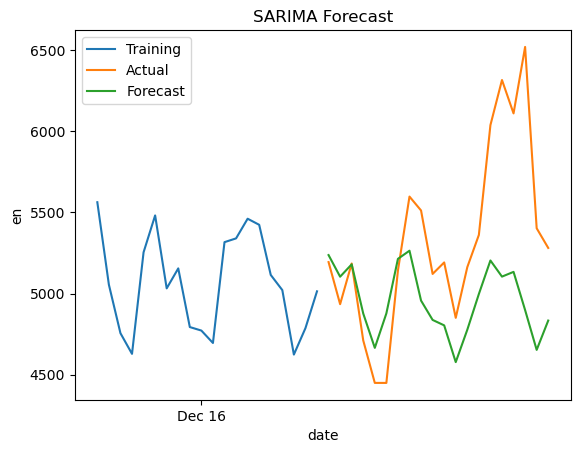

In [33]:
plot_forecast(train[-20:], test, fc_series, "SARIMA Forecast")

**Model Evaluation:** Logged metrics into MLflow for later assessment and comparison. Used the predefined `performance()` function to compute:  
  - **RMSE = 624.16** & **MAPE = 8.44%**  

The **SARIMA_Forecast run** is now available in MLflow under `localhost:5000/#/experiments/<experiment_id>/runs/<run_id>` providing a central record of model parameters, metrics, and artifacts.  

Forecast visualization of **train, test, and forecasted series** shows:  
  - The forecast tracks the general pattern but tends to **underpredict** actual values. A sharp rise in the test data is not captured by the model.  

**Insight:** This deviation may be explained by incorporating **exogenous variables**, which can capture external events influencing webpage views.

### 1.2 SARIMAX 

SARIMAX (SARIMA with Exogenous Regressors) builds on SARIMA by adding support for **exogenous variables (exog)** binary indicator (`0/1`) for external factors (campaign or significant event) that may influence the time series. This makes it powerful for use cases where **outside events, holidays, promotions, or campaigns** are given to predict the time series with affect.

**Preparing Exogenous Data:** Read the provided **exogenous variable** into a dataFrame, which was captured for the campaign dates for resulting in increased webpage view counts. Apply the same **datetime index** as the main time series, ensuring the model knows when external events occurred. Create MLflow dataset object like previously done for the exogenous dataFrame with its **source path**. Both the time series input and the **exogenous input** will be logged in the next experiment run.  

**Experiment Setup:** Using same **train-test split** (last 20 days for testing). Configure MLflow run with input datasets (time series + exogenous variable), SARIMAX parameters, performance metrics, serialized model artifact. 

**Model with Exogenous Variables**
- Fit the SARIMAX model on the training input along with the exogenous series.
- The model accounts for **external campaign events**, helping explain sudden changes in webpage views.  
- With the same `order (4,1,3)` and `seasonal_order (3,0,2,7)`, forecasted **20 days** ahead.  

In [115]:
exog_df = pd.read_csv('Exog_Campaign_eng')
exog_df.index = en_ts.index
exog_df.index = pd.to_datetime(exog_df.index, format='ISO8601', dayfirst=True)
# exog_df.head(3)
exog_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exog    550 non-null    int64
dtypes: int64(1)
memory usage: 24.8 KB


In [36]:
# exog_df.to_csv("en_exog_ts.csv")

# Create a Dataset object
en_exog_dataset = mlflow.data.from_pandas(exog_df, source="./en_exog_ts.csv", 
                                        name="en_page_exog_ts", targets="Exog")

C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for './en_exog_ts.csv'. Exception: 
  return _dataset_source_registry.resolve(
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


In [42]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run(run_name="SARIMAX_forecast"):
    # Log input data
    mlflow.log_input(en_ts_dataset, context='timeseries')
    mlflow.log_input(en_exog_dataset, context='exogenous')
    mlflow.log_artifact("en_ts.csv")
    mlflow.log_artifact("en_exog_ts.csv")
    
    model = SARIMAX(train, order=(4,1,3), seasonal_order=(3,0,2,7),
                     exog=exog_df.loc[train.index])
    model_fit = model.fit()
    fc = model_fit.get_forecast(20, exog=exog_df.loc[test.index]).predicted_mean
    fc_series = pd.Series(fc.values, index=test.index)
    rmse, mape_val = performance(test, fc_series)

    # Log params and metrics
    mlflow.log_params({"order": order, "seasonal_order": seasonal_order, "steps": steps})
    mlflow.log_metrics({"mape": mape_val, "rmse": rmse})

    # input_example = {"train": train.head(), "exogenous": exog_df.head()}  # dict to log both datasets
    mlflow.sklearn.log_model(sk_model=model_fit, name="SARIMAX fitted model",
        serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE:  397.22
MAPE:  0.0607


2025/10/05 23:59:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SARIMAX_forecast at: http://127.0.0.1:5000/#/experiments/0/runs/593e8df039354a0fa9ed35209db5ece5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


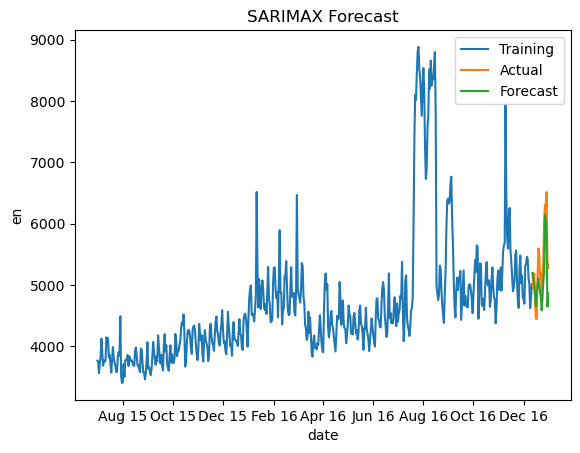

In [39]:
plot_forecast(train, test, fc_series, "SARIMAX Forecast")

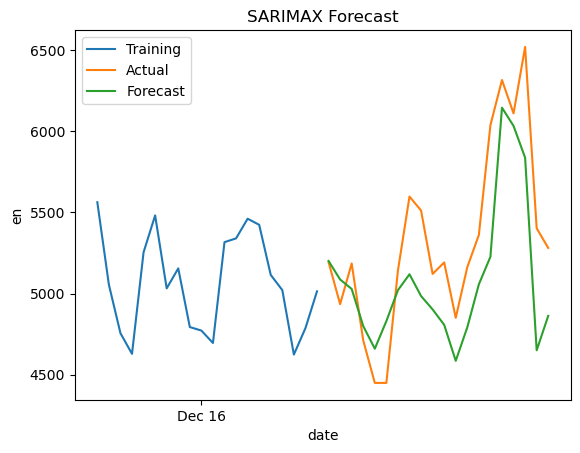

In [40]:
plot_forecast(train[-20:], test, fc_series, "SARIMAX Forecast")

Model evaluation using the predefined `performance()` function to compute:
  - **RMSE = 398.95** & **MAPE = 6.1%**  
Theres is a **significant improvement** over the SARIMA (without exogenous inputs).  

The results of the **SARIMAX_Forecast run** are also available in MLflow's localhost experiment run records with datasets (mainseries + exogenous), parameters, metrics and serialized model.  

Forecast visualization with exogenous inputs the model **predictions align better** with the peaks and troughs of the test series. Capturing sudden spikes caused by external events, which were missed in the earlier run.  

**Key Insight:** Including **exogenous variables** makes the SARIMAX model more robust, improving both accuracy and interpretability.


### 1.3 SARIMAX with Auto Arima

**Auto ARIMA (`pmdarima.auto_arima`)** provides library pmdarima, which can be used to calc optimal hyperparameters for the time series model i.e. best combination of parameters for SARIMAX using statistical tests like AIC/BIC. It works by conducting differencing tests to determine the order of differencing, d, and then fitting models within defined range for p, q, etc.
  
Note: pmdarima requires older numpy version 1.26, tuned model in different notebook and just plugged in the optimal values here,
as our moto here was to compare models.

**Experiment Setup:** Same **train-test split** and MLflow run configuration.

**SARIMAX Model tuned Hyperparameters**:
- We use **SARIMAX** model with **tuned hyperparmeters** using auto arima.  
- Pass training series, exogenous variable with optimised `order (0,1,0)` and `seasonal_order (3,0,1,7)` to fit model.  
- Generate **20-day forecasts** of daily webpage view counts.  

In [1]:
# !pip install pmdarima 
# !pip install numpy==1.26

# from pmdarima.arima import auto_arima

# model = auto_arima(en_ts, seasonal=True, m=7, start_p=0, max_p=4, start_q=0, max_q=3,
                   # start_P=0, max_P=7, start_Q=0, max_Q=7, max_d=1, max_D=1,
                   # stepwise=True, suppress_warnings=True, information_criterion='aic')

In [43]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run(run_name="SARIMAX_hyperparam_forecast"):
    # Log data
    mlflow.log_input(en_ts_dataset, context='timeseries')
    mlflow.log_input(en_exog_dataset, context='exogenous')
    
    order = (0,1,0); seasonal_order = (3,0,1,7);  # params
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, exog=exog_df.loc[train.index])
    model_fit = model.fit()  # model from pdarima
    
    fc = model_fit.get_forecast(steps, exog=exog_df.loc[test.index]).predicted_mean
    fc_series = pd.Series(fc.values, index=test.index)
    rmse, mape_val = performance(test, fc_series)

    # Log params and metrics
    mlflow.log_params({"order": order, "seasonal_order": seasonal_order, "steps": steps})
    mlflow.log_metrics({"mape": mape_val, "rmse": rmse})
    
    mlflow.sklearn.log_model(sk_model=model_fit, name="SARIMAX hyperparam fitted model",
    serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)

C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE:  409.16
MAPE:  0.0618


2025/10/06 00:08:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SARIMAX_hyperparam_forecast at: http://127.0.0.1:5000/#/experiments/0/runs/2ed2d0fce34e49f48c8c5e5b017f15b0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


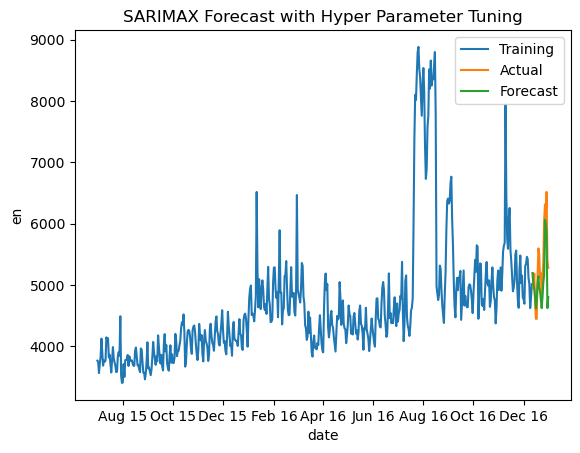

In [47]:
plot_forecast(train, test, fc_series, "SARIMAX Forecast with Hyper Parameter Tuning")

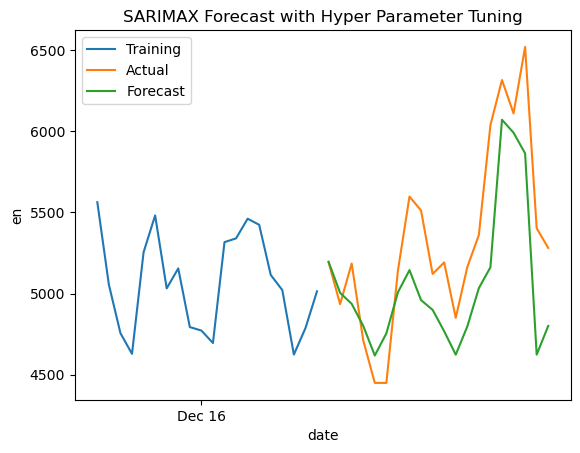

In [48]:
plot_forecast(train[-20:], test, fc_series, "SARIMAX Forecast with Hyper Parameter Tuning")

Tuned model evaluation using the `performance()` function, we compute:
  - **RMSE = 409.15** & **MAPE = 6.18%**  
It has almost **same** performance as the SARIMAX (exogenous inputs) in MAPE value but has more RMSE. Since the order for AR (p) and MA (q) is zero, it missed to fully follow the actual values like the SARIMAX model before, but aligns better.

The results of the **SARIMAX_Hyperparam_Forecast run** are also available in MLflow's localhost experiment run records with its respective performance metrics. 

Forecast visualization with hyperparameter tuned model shows, **predictions align** with the test series but a little less compare to previous model.

**Key Insight:** Including exogenous variables with **hyperparameter tuning** makes the SARIMAX model robust, with the ability to find these optimal order values using auto arima. 


### 2.1 Facebook Prophet

Prophet is an **additive model** where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have **strong seasonal effects** and several seasons of historical data. Prophet is robust to **missing data** and shifts in the trend, and typically **handles outliers** well. It is **fast** and provides **automated forecast** than can be tuned further by hand. It internally uses `pystan` for quick and efficient statistical calculation to perform bayesian inference and find the optimal parameters. 

FB Prophet considers time series as, 
$y(t) = g(t) + s(t) +h(t) + e(t)$ <br>
Where $g(t)$ trend of series (linear or logistic), $s(t)$ seasonality, $h(t)$ holiday effect (exogenous regressor), $e(t)$ residual / error term

**Hyperparameters** of Prophet model
1. **Trend / Growth**: 
   * **Linear**: Works well when the time series shows a steady increase or decrease. Can also capture non-linear changes if the pattern repeats over time.
   * **Logistic**: Used when the trend shows saturation (a natural maximum or minimum). Suitable when growth slows down after reaching capacity.

2. **Prior scales**: **Changepoint prior scale** controls the flexibility of the trend, **Seasonality prior scale** determines the strength/weight given to seasonal effects, Similarly **Holiday prior scale** is weight for holiday effects.

3. **Seasonality**: Automatically models **daily, weekly, and yearly seasonality** depending on the dataset. Accordingly turn on/ off or add new seasonality effects. 

4. **Other hyperparameters**: Several additional tuning options such as the number of changepoints, interval width for uncertainty estimates, and specifying external regressors.

**Preparing Data:** FB Prophet requires the dataset in a standard format with columns named **`ds`** (datetime) and **`y`** (time series values). Rename the input DataFrame accordingly. As with the earlier experiment, create an **MLflow dataset object** with the DataFrame, its **source path**, and specify the **target as `y`** for consistency.

**Experiment Setup:** Configure an MLflow run named **Prophet_Forecast**, using the same **train-test split** (last 20 days for testing). Log run, use extention for logging prophet models `prophet.log_model` with an input example.

**Set tracking URI** to `localhost` and start run with the alias **`Prophet_Forecast`**.
- Track new hyperparameters required in this model
- As discussed earlier we log trained model artifact with prophet log model function.  

**Prophet Model**
* We use **Prophet** from  facebook `prophet`. Initialize with default parameters and adjusted **`seasonality_prior_scale = 50`** due to strong seasonality in the dataset, **weekly seasonality enabled**.
* Fit the model on the training data and use `make_future_dataframe` to extend the timeline for predictions.
* Apply **fit** and **predict** to generate the forecasted values (also give upper and lower bound values) for the test horizon.
* Prophet provides a built-in **`.plot()`** method to visualize the fitted time series and the forecast.


In [1]:
# !pip install pystan
# !pip install prophet

In [54]:
df_prophet.to_csv("prophet_ts.csv", index=False)

# Create a Dataset object
prophet_ts_dataset = mlflow.data.from_pandas(df_prophet, source="./prophet_ts.csv", 
                                        name="prophet_ts_df", targets="y")

C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for './prophet_ts.csv'. Exception: 
  return _dataset_source_registry.resolve(
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


In [52]:
from prophet import Prophet
Prophet?

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
    scaling: str = 'absmax',
    holidays_mode=None,
)
Docstring:      <no docstring>
File:           c:\users\pavan\miniconda3\envs\ml\lib\site-packages\prophet\forecaster.py
Type:           type
Subclasses:     

In [55]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run(run_name="Prophet_Forecast"):
    # Log data
    mlflow.log_input(prophet_ts_dataset, context='prophet_timeseries')
    
    model = Prophet(seasonality_prior_scale=50, weekly_seasonality=True,)
    model_fit = model.fit(df_prophet[:-20])
    
    # Create future dataframe
    future = model_fit.make_future_dataframe(periods=len(df_prophet[-20:]), freq='D')
    
    forecast = model_fit.predict(future)
    rmse, mape_val = performance(df_prophet['y'][-20:], forecast['yhat'][-20:])

    # Log params and metrics
    mlflow.log_params({"n_changepoints":25, "changepoint_prior_scale": 0.05, "seasonality_prior_scale":50,
                       "holidays_prior_scale":10, "weekly_seasonality": True, "steps": 20})
    mlflow.log_metrics({"mape": mape_val, "rmse": rmse})
    
    mlflow.prophet.log_model(pr_model=model_fit, name="prophet_fitted_model",
        input_example=df_prophet.head())

00:16:58 - cmdstanpy - INFO - Chain [1] start processing
00:16:58 - cmdstanpy - INFO - Chain [1] done processing


RMSE:  662.57
MAPE:  0.0868


🏃 View run Prophet_Forecast at: http://127.0.0.1:5000/#/experiments/0/runs/c693fc2232414ad184f670d02c69a7ea
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


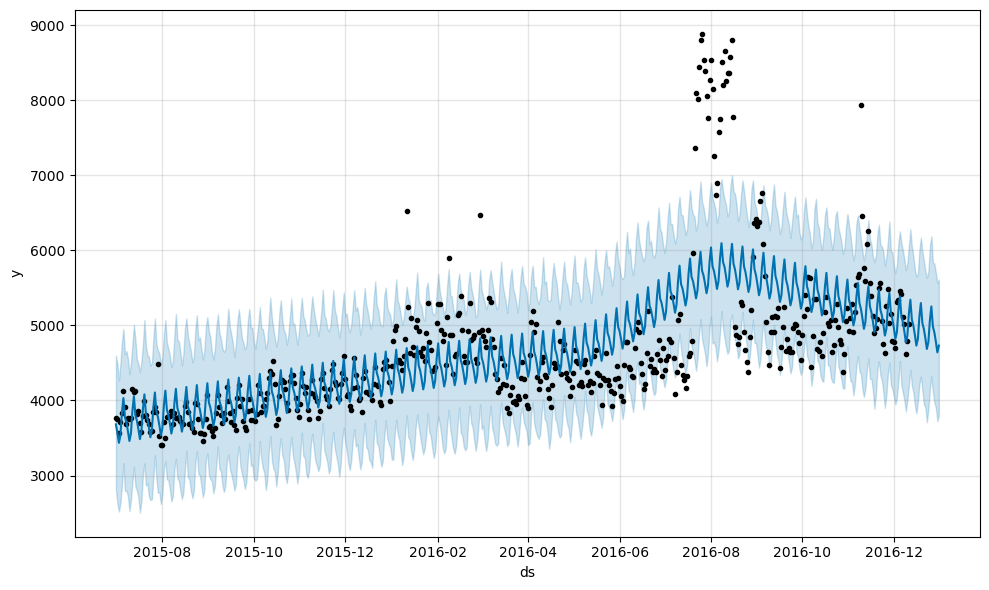

In [56]:
fig = model_fit.plot(forecast)

Custom Seasonality: If data has a cycle not covered (e.g. 7-day, 30-day, quarterly), add it manually: model.add_seasonality(name="monthly", period=30.5, fourier_order=5)

In [27]:
# mlflow.set_tracking_uri("http://127.0.0.1:5000/")  # not required, without ex variable, we will only overfit the data
# with mlflow.start_run(run_name="Prophet_forecast"):
#     # Log data
#     mlflow.log_input(prophet_ts_dataset, context='prophet_timeseries')

#     model = Prophet(changepoint_prior_scale=0.075, weekly_seasonality=True)
#     model.fit(df_prophet[:-20])
    
#     # Create future dataframe
#     future = model.make_future_dataframe(periods=len(df_prophet[-20:]), freq='D')
    
#     forecast = model.predict(future)
#     rmse, mape_val = performance(df_prophet['y'][-20:], forecast['yhat'][-20:])

#     # Log params and metrics
#     mlflow.log_params({"changepoint_prior_scale": 0.075, "weekly_seasonality": True, "steps": 20})
#     mlflow.log_metrics({"mape": mape_val, "rmse": rmse})
    
#     mlflow.sklearn.log_model(sk_model=model_fit, name="prophet fitted model",
#     serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)
    # mlflow.prophet.log_model(pr_model=model, name="prophet_model", input_example=df[["ds"]].head()) format example?

In [28]:
# fig = model.plot(forecast)

Prophet model evaluation using the `performance()` function, we compute:
  - **RMSE = 662.57** & **MAPE = 8.68%**    
The model performs similar to SARIMA(without exogoneous variable) model by default i.e without analysing time series and finding optimal orders. 

The results of the **Prophet_Forecast run** are also available in MLflow's localhost experiment run for comparison.  

Forecast visualization shows forecast has a downward trend opposite to that of the actual values due to prior increase in views due to events effect (exogenous). 

**Insight:** Without **Holiday effect** (exogenous variable) the FB prophet model is unable to catch the trend due to high variability in the time series during events.

### 2.2 FB Prohpet with Holiday Effect

**Preparing Data:** To incorporate an **holiday/campaign effect** (exogenous variable) for the webpage views into Prophet, create a new DataFrame of exogenous variable with the same datetime index as main series and merge it on the `ds` column. This results in a dataset containing `ds`, `y`, and `Exog` columns. Create a new **MLflow dataset object** for this DataFrame, keeping the target column as `y` since the task remains predicting webpage views.

**Experiment Setup:** Use the same MLflow tracking setup as before. During the run, log the updated dataset along with the new model hyperparameters. Record the experiment under a new run name `Prophet_Exog_Forecast` to differentiate results.

**Prophet with Exogenous Regressor**

* Configure the Prophet model with optimized hyperparameters:
  * `n_changepoints = 30` considers entire month's series before shifting trend.
  * `changepoint_prior_scale = 0.1` to control the weight given to recent changepoints.
  * `seasonality_prior_scale = 50` and `holiday_prior_scale = 50` to emphasize seasonal and holiday patterns.
* Add the exogenous variable using `.add_regressor()`, allowing the model to account for external holiday effects.
* Fit and predict 20-day forecasts, log run and visualize fit using `.plot()`


In [121]:
exog_df = exog_df.reset_index()
exog_df.columns = ['ds', 'Exog']

df_prophet_ex = pd.merge(df_prophet, exog_df, on='ds')
df_prophet_ex.info()
# df_prophet_ex.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      550 non-null    datetime64[ns]
 1   y       550 non-null    float64       
 2   Exog    550 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 13.0 KB


In [58]:
df_prophet_ex.to_csv("prophet_exog.csv", index=False)

# Create a Dataset object
prophet_exog_dataset = mlflow.data.from_pandas(df_prophet_ex, source="./prophet_exog.csv", 
                                        name="prophet_exog_df", targets="y")

C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for './prophet_exog.csv'. Exception: 
  return _dataset_source_registry.resolve(
C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\mlflow\data\dataset_source_registry.py:148: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


In [59]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run(run_name="Prophet_Exog_Forecast"):
    # Log data
    mlflow.log_input(prophet_ts_dataset, context='prophet_exog_ts')

    model_ex = Prophet(n_changepoints=30, changepoint_prior_scale=0.1, seasonality_prior_scale=50,
                       holidays_prior_scale=50, weekly_seasonality=True) 
    model_ex.add_regressor('Exog')  # register exogenous variable
    
    model_ex_fit = model_ex.fit(df_prophet_ex[:-20])
    forecast = model_ex_fit.predict(df_prophet_ex)
    
    rmse, mape_val = performance(df_prophet['y'][-20:], forecast['yhat'][-20:])

    # Log params and metrics
    mlflow.log_params({"n_changepoints":30, "changepoint_prior_scale": 0.1, "seasonality_prior_scale":50,
                       "holidays_prior_scale":50, "weekly_seasonality": True, "steps": 20})
    mlflow.log_metrics({"mape": mape_val, "rmse": rmse})
    
    mlflow.prophet.log_model(pr_model=model_ex_fit, name="prophet exog fitted model",
        input_example=df_prophet_ex.head())

00:18:54 - cmdstanpy - INFO - Chain [1] start processing
00:18:54 - cmdstanpy - INFO - Chain [1] done processing


RMSE:  465.05
MAPE:  0.065


C:\Users\pavan\miniconda3\envs\ml\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run Prophet_Exog_Forecast at: http://127.0.0.1:5000/#/experiments/0/runs/4e6cc05f761e4e0faf0646ce74465d53
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


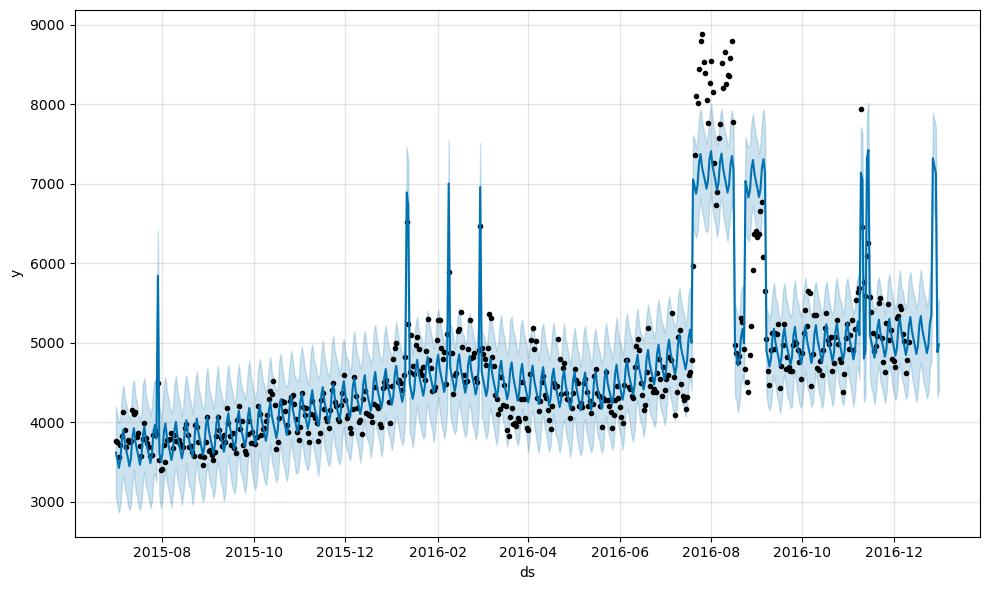

In [73]:
fig = model_ex_fit.plot(forecast)

In [ ]:
# df_prophet_ex.set_index('ds', inplace=True)
# df_prophet_ex.info()
fc_series = forecast['yhat'][-20:]
fc_series.index = df_prophet_ex[-20:].index
# fc_series

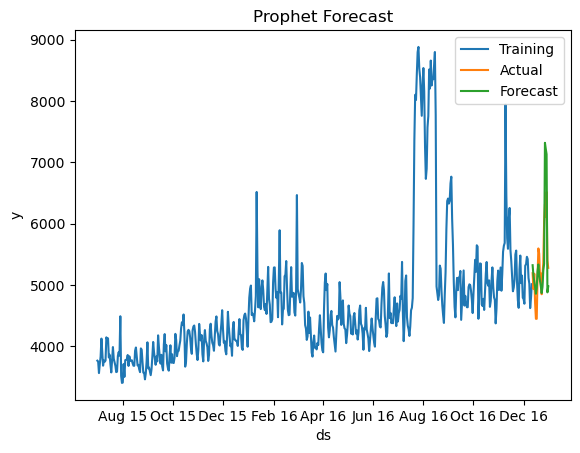

In [78]:
plot_forecast(train=df_prophet_ex['y'][:-20], test=df_prophet_ex['y'][-20:], 
              fc_series=fc_series, title="Prophet Forecast")

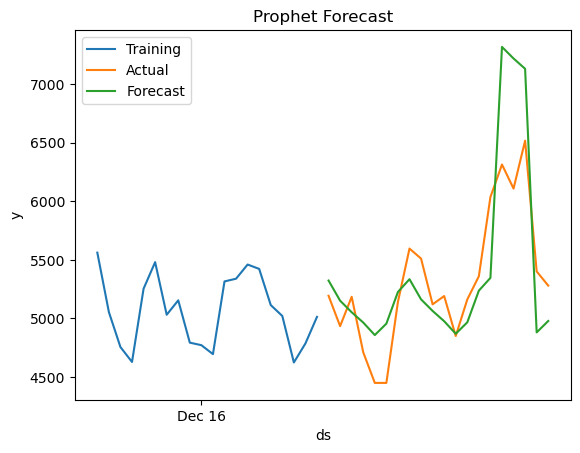

In [79]:
plot_forecast(train=df_prophet_ex['y'][-40:-20], test=df_prophet_ex['y'][-20:], 
              fc_series=fc_series, title="Prophet Forecast")

Prophet model evaluation using the `performance()` function, we compute:
  - **RMSE = 465.05** & **MAPE = 6.5%**    

The model showing improved fit when incorporating the exogenous variable, close to SARIMAX model, with efforts to find optimal hyperparameters. The results stored at localhost for comparison.  

Forecast visualization shows forecast are aligning with the actual values but have underpredicted or overshoot the predictions.

**Insight:** With **Holiday effect** the FB prophet model has predict trend and daily seasonality in the time series during events.

### 3. PatchTST (TSAI)
(* Here we are experimenting with Transformer based time series models, due to limited understanding. So the implementation may not be optimal.)

**PatchTST** leverages the **transformer architecture** by segmenting the input time series into subseries-level patches, enabling the model to capture both local and global pattern recognition more effectively. Combined with the **tsai library**, it simplifies implementation by wrapping these complex deep learning operations into high-level functions for fast experimentation

Data Preparation
* The dataset contains **daily view counts** of english webpages as target column `y`, with **binary flag column (1/0)** marking event days (exogenous variable) as exogenous column `"exog"` and datetime index
* Since deep learning models expect numerical matrix inputs **(tensors or NumPy arrays)**, the data is passed as NumPy values.
* train-test split defined earlier cant be used as set of inputs and forecast output is passed to the model. It predicts on single input once but for the entire forecast range. 

* **Sliding window** and **time split** objects are used to generate model inputs (forecast 20 steps with 30 days history as optimal window size, seen in prophet model):
  * **Window = 30**: each training sample uses the last 30 data points as input (history).
  * **Horizon = 20**: each training sample forecasts the next 20 steps into the future.
* Split Cutoff at **500** because the model requires both 30 datapoints (history) and 20 datapoints (forecast horizon) for each sequence, fully utilizing the available 550 datapoints.
* Create **dataset object** in MLflow with Dataframe, source, etc

(batch transformation function transforms the input in a suitable format for deep learning models. We didn't experiment as dataset is simple.)


In [ ]:
# !pip install tsai
# !pip install numpy==1.26.4  # requires older version

In [80]:
from tsai.basics import *

# tfms = [None, TSForecasting()]
# batch_tfms = TSStandardize()  # exc_vars=''

In [139]:
# perform data loading steps
df_ex = df_prophet_ex.set_index("ds").copy()
# df_ex = pd.merge(en_ts_df, exog_df, left_index=True, right_on=['ds'], how='inner')
df_ex.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       550 non-null    float64
 1   Exog    550 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 12.9 KB


In [140]:
ts_ex = df_ex.values
ts_ex

array([[3.76732860e+03, 0.00000000e+00],
       [3.75515877e+03, 0.00000000e+00],
       [3.56522570e+03, 0.00000000e+00],
       ...,
       [6.51805853e+03, 1.00000000e+00],
       [5.40179236e+03, 0.00000000e+00],
       [5.28064347e+03, 0.00000000e+00]])

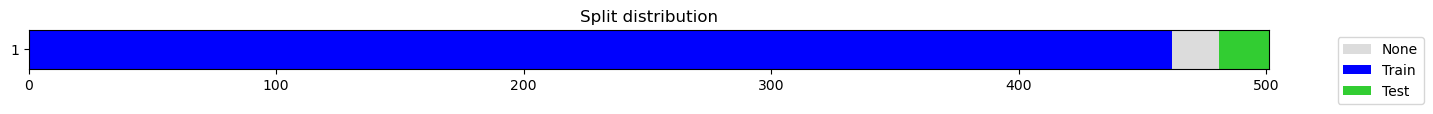

(501, 2, 30)
(501, 2, 20)


In [141]:
# splits = get_forecasting_splits(df_ex, fcst_history=30, fcst_horizon=20, test_size=20)
X, y = SlidingWindow(30, horizon=20)(df_ex)
splits = TimeSplitter(20, fcst_horizon=20)(y)
splits

print(X.shape)
print(y.shape)
# X

In [85]:
# df_ex.to_csv("tsai_ex_df.csv")

# Create a Dataset object
tsai_ex_dataset = mlflow.data.from_pandas(df_ex, source="./tsai_ex_df.csv", 
                                        name="en_page_exog_ts", targets="y")

# np.savez("ts_splits.npz", train=splits[0], valid=splits[1])

**TSForecaster** from the `tsai` library is used to build the forecasting model.
* Key parameters passed are (`path`) models directory, (`batch size`) no. of inputs in each iteration, (`architecture`) as PatchTST that we use, (`metrics`) MAE - mean abosolute error, (`callbacks`) `ShowGraph` to visualize training/validation loss and metrics
* `model.summary` provides the PatchTST **model architecture** (input, hidden layers, activation function, transforms, optimizer, trainable parameters, etc)

**Experiment Setup:** Using the same MLflow experiment tracking, run created with name `PatchTST_forecast`.

**PatchTST model**
* Training used `fit_one_cycle` learning rate scheduler (learning rate increases in the first half, decreases in the second half of epochs).
* `get_X_preds` function used to generate predictions. Since the model predicts a block of future values for each input, the **last block’s forecast** was taken as the final prediction series.
* **Performance function** (RMSE + MAPE) applied to evaluate predictions against the test set.
* MLflow logged parameters `epochs`=10, `learning_rate`=1e-3, `batch_size`=32, `architecture`=PatchTST, `forecast_history`=30, `horizon`=20
* log metrics (RMSE, MAPE), model artifact (serialized using sklearn-compatible format; pyfunc also supports).
* Callback outputs training and validation loss, MAE performance metric with time taken per epoch during training. 


In [149]:
# fcst = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=batch_tfms, bs=512, arch="TSTPlus", metrics=mae, cbs=ShowGraph())
fcst = TSForecaster(X, y, splits=splits, path='models', bs=32, arch="PatchTST", metrics=mae, cbs=ShowGraph())  # no transforms
fcst.summary()

not enough values to plot a chart


PatchTST (Input shape: 32 x 2 x 30)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 2 x 20         
RevIN                                     4          True      
____________________________________________________________________________
                     32 x 2 x 38         
ReplicationPad1d                                               
____________________________________________________________________________
                     32 x 16 x 3         
Unfold                                                         
____________________________________________________________________________
                     32 x 2 x 3 x 512    
Linear                                    8704       True      
Dropout                                                        
Linear                                    262656     True      
Linear                                    262656     True      
Linear                                    262656     

epoch,train_loss,valid_loss,mae,time
0,426814.093750,166549.843750,231.837112,00:05
1,360468.250000,189623.984375,248.419098,00:04
2,342285.250000,282427.562500,295.222534,00:04
3,326179.437500,231103.453125,272.556610,00:05
4,309522.968750,163035.359375,227.591751,00:04
5,290313.781250,136537.828125,213.802887,00:04
6,275407.843750,140951.906250,221.146194,00:05
7,256158.875000,134213.546875,211.156448,00:05
8,239304.031250,140875.703125,212.933136,00:05
9,220915.421875,141262.937500,214.183258,00:04


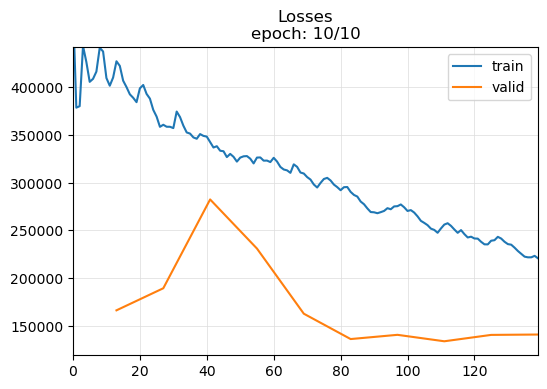

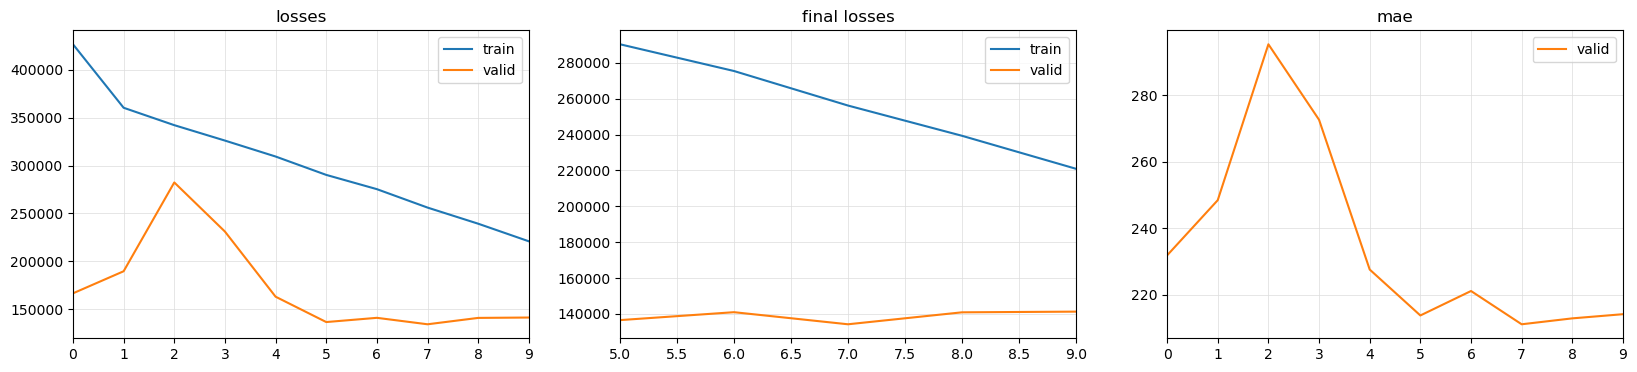

In [150]:
fcst.fit_one_cycle(10, 1e-3)

In [149]:
# Make predictions on validation set
# preds, *_ = fcst.get_X_preds(X[splits[1]])

# performance with actual series, first index '19' to get preds from the last input,
# second index '0' is to specify, we want pred for time series, and not exog variable
# type(preds[19][0])
# print("Prediction:", preds[19])  # it gives pred for both timeseries and ex

# print(len(preds.flatten()), len(y[splits[1]].flatten())) 
# performance(preds.flatten(), y[splits[1]].flatten())

# performance(df_ex['y'][-20:], np.array(preds[19][0]))
# problem here is it does not get exog directly as input the model; 
# trained till 470, tested till 500; has 30 history and 20 forecast, spanning entire 550 datapoints

In [154]:
preds, *_ = fcst.get_X_preds(X[splits[1]])  # Make predictions on validation set
rmse, mape_val = performance(df_ex['y'][-20:], np.array(preds[19][0]))

RMSE:  479.25
MAPE:  0.0661


In [151]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run(run_name="PatchTST_Forecast"):
    mlflow.log_input(tsai_ex_dataset, context='numpy timeseries')
    mlflow.log_artifact("ts_splits.npz")
    
    # fcst.fit_one_cycle(10, 1e-3)
    # fcst.export("fcst.pkl")
    preds, *_ = fcst.get_X_preds(X[splits[1]])  # Make predictions on validation set
    rmse, mape_val = performance(df_ex['y'][-20:], np.array(preds[19][0]))

    # Log params and metrics
    mlflow.log_params({"epochs":10, "learning_rate": 1e-3, 'bs': 32, 'arch': "PatchTST", 
                       'metrics': 'mae', 'fcst_history': 30, 'fcst_horizon': 20, 'test_size': 20})
    mlflow.log_metrics({"mape": mape_val, "rmse": rmse})
    
    mlflow.sklearn.log_model(sk_model=fcst, name="PatchTST model",
        serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE, input_example=df_ex.head())

2025/10/06 01:30:13 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: TypeError("'NoneType' object is not iterable"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


RMSE:  479.25
MAPE:  0.0661


2025/10/06 01:30:32 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "y.... Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input example using `mlflow.models.convert_input_example_to_serving_input` function.
Got error: 'NoneType' object is not iterable


🏃 View run PatchTST_Forecast at: http://127.0.0.1:5000/#/experiments/0/runs/8deab7d38d584f3f88f254aa6325ceba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [103]:
# df_patch_pred = df_ex['y'][-20:].to_frame('y').copy()
# df_patch_pred['y'] = np.array(preds[19][0])
# df_patch_pred['y'].info()  # not required
# df_patch_pred['y'][-20:]

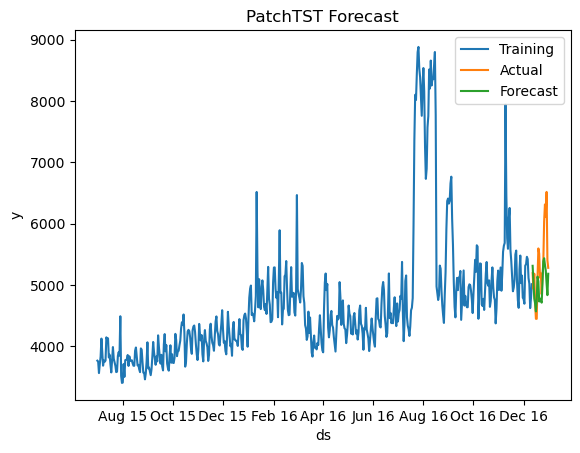

In [155]:
plot_forecast(df_ex['y'][:-20], df_ex['y'][-20:], df_patch_pred['y'], "PatchTST Forecast")  # it doesnt get exogeneous value directly as input to predict against it

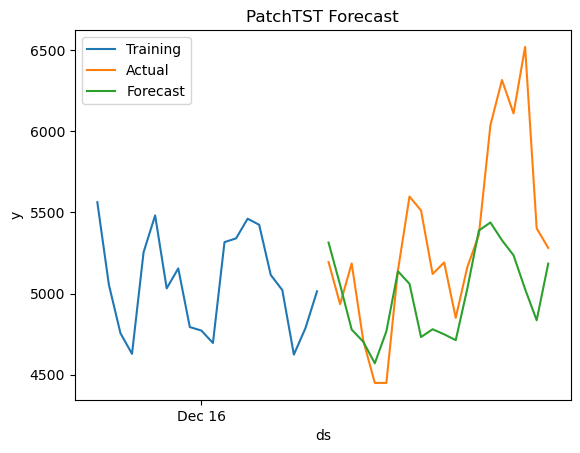

In [156]:
plot_forecast(df_ex['y'][-40:-20], df_ex['y'][-20:], df_patch_pred['y'], "PatchTST Forecast") 

PatchTST model evaluation using the `performance()` function, we compute:
- **RMSE = 479.93** & **MAPE = 6.61%** | **MAE settled at ~220**.

* The model **underfitted** - Training loss was still decreasing but validation loss stagnated, suggesting limited capacity or suboptimal tuning.
* Issue here is model predict the exogenous variable as well, instead of using it to adjust forecasts. This is incorrect, since event flags (campaigns/holidays) should be used to explain variance in the trend.

* The model produced forecasts for the 20-step horizon. Alongside predictions, outputs also included exogenous variable estimates hence we use slicing method to select only the forecasted time series from the last validation data input. e.g. `preds[last_input][timeseries]`

Again, the results of the **PatchTST_Forecast run** are available in MLflow's localhost experiment run.

Forecast visualization shows model just aligning and under predicted the actual values.

**Key Insight:** RMSE and MAPE value near to the SARIMAX model. PatchTST found non linear relationships in data, but failed to use regressor for changing trends due to events. 

> Forecast visual comparison of above three models

In [126]:
# SARIMAX Forecasts
# model = SARIMAX(en_ts_df['en'][:-20], order=(4,1,3), seasonal_order=(3,0,2,7),
#                      exog=exog_df[:-20])
# model_fit = model.fit()
# fc = model_fit.get_forecast(20, exog=exog_df[-20:]).predicted_mean
# sarimax_fc_series = pd.Series(fc.values, index=en_ts_df[-20:].index)

# Prophet Forecasts
# model_ex = Prophet(n_changepoints=30, changepoint_prior_scale=0.1, seasonality_prior_scale=50,
#                        holidays_prior_scale=50, weekly_seasonality=True) 
# model_ex.add_regressor('Exog')  # register exogenous variable
# model_ex_fit = model_ex.fit(df_prophet_ex[:-20])
# forecast = model_ex_fit.predict(df_prophet_ex)
# prophet_fc_series = pd.Series(forecast['yhat'][-20:].values, index=en_ts_df[-20:].index)

# PatchTST Forecasts
# fcst = TSForecaster(X, y, splits=splits, path='models', bs=32, arch="PatchTST", metrics=mae, cbs=ShowGraph())  # no transforms
# fcst.fit_one_cycle(10, 1e-3)
# preds, *_ = fcst.get_X_preds(X[splits[1]])
# patchtst_fc_series = pd.Series(np.array(preds[19][0]), index=en_ts_df[-20:].index) 

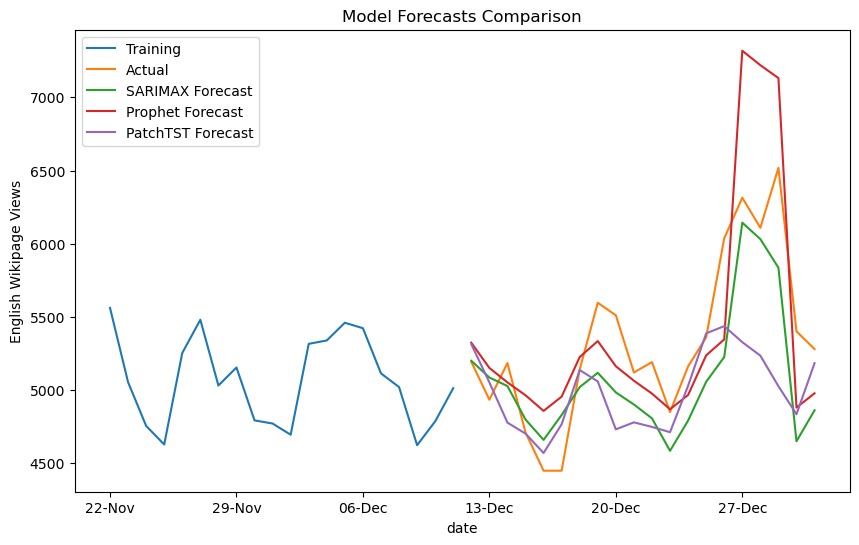

In [157]:
plt.figure(figsize=(10,6))
sns.lineplot(en_ts_df['en'][-40:-20], label='Training')
sns.lineplot(en_ts_df['en'][-20:], label='Actual')
sns.lineplot(sarimax_fc_series, label='SARIMAX Forecast')
sns.lineplot(prophet_fc_series, label='Prophet Forecast')
sns.lineplot(patchtst_fc_series, label='PatchTST Forecast')

plt.title("Model Forecasts Comparison")
plt.legend()
plt.ylabel('English Wikipage Views')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.show()

## References:
1. [Statsmodels time series analysis](https://www.statsmodels.org/dev/user-guide.html#time-series-analysis)
2. [Statsmodels SARIMAX Model Documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX)
3. [MLFlow Documentation](https://mlflow.org/docs/3.2.0/ml/)
4. [Facebook Prophet Documentation](https://facebook.github.io/prophet/)
5. [TSAI Github Repository](https://github.com/timeseriesAI/tsai)
6. [PatchTST Implementation Guide](https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/15_PatchTST_a_new_transformer_for_LTSF.ipynb)

### Future work:
- Auto logging, validating and deploying models with MLFlow runs. 
- Better handling of external regressors in PatchTST and exploring more transformer architectures.